In [1]:
import pandas as pd
import numpy as np

# Считываем данные
dataneg = pd.read_csv('negative.csv', header = None, sep=';', comment='#')
datapos = pd.read_csv('positive.csv', header = None, sep=';', comment='#')

In [2]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])#Делаем одинаковое количество негативынх и позиитвных твитов
raw_data = np.concatenate((data_positive['text'].values[:sample_size],#Соединяем
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [3]:
def replaceemoji_text(text):# Заменяем смайлы
    text = text.replace (":D"," улыбка")
    text = text.replace (":-D"," улыбка")
    text = text.replace ("=)"," улыбка")
    text = text.replace (":)"," улыбка")
    text = text.replace (":-)"," улыбка")
    text = text.replace (";)"," улыбка")
    text = text.replace (":("," грусть")
    text = text.replace (":|"," недоумение")
    text = text.replace (":-("," грусть")
    text = text.replace (":*"," улыбка")
    text = text.replace ("%)"," удивление")
    return text.strip()
raw_data = [replaceemoji_text(t) for t in raw_data]

In [4]:
import re


def ReplaceTreeorMore(text):# Если в слове больше двух одинаковых букв, идущих подрядл, меняем на две одинаковые буквы
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1\1", text)
raw_data = [ReplaceTreeorMore(t) for t in raw_data]

In [5]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")# Меняем ё на е
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)# Меняем ссылки на URL
    text = re.sub('@[^\s]+', 'USER', text)# Пользователя на User
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)# Убираес все прочие занки кроме букв и цифр
    text = re.sub(' +', ' ', text)
    return text.strip()


raw_data = [preprocess_text(t) for t in raw_data]

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.2, random_state=2)

In [7]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


Using TensorFlow backend.


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Высота матрицы (максимальное количество слов в твите)
SENTENCE_LENGTH = 26
# Размер словаря
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

# Cоздаем и обучаем токенизатор
tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

# Отображаем каждый текст в массив идентификаторов токенов
x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [9]:
from gensim.models import Word2Vec
# Загружаем обученную модель
w2v_model = Word2Vec.load('tweets_model.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

2 варианта LSTM модели. Вторая показала себя немного лучше

In [13]:
#from keras.models import Sequential 
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical


#model = Sequential()
#model.add(Embedding(NUM, DIM,input_length  = SENTENCE_LENGTH, weights=[embedding_matrix], trainable=False))
#model.add(SpatialDropout1D(0.4))
#model.add(Bidirectional(LSTM(196, dropout=0.2, recurrent_dropout=0.2)))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics= ['accuracy',precision, recall, f1])
#print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 26, 200)           20000000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 26, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 392)               622496    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 393       
Total params: 20,622,889
Trainable params: 622,889
Non-trainable params: 20,000,000
_________________________________________________________________
None


In [16]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)
layer = LSTM(64)(tweet_encoder)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(tweet_input,outputs=layer)

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary() # Модель с замороженными emdedding слоям

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 26, 200)           20000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [18]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("LSTM-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history = model.fit(x_train_seq, y_train, epochs = 7, batch_size=32,validation_split=0.25, callbacks = [checkpoint])

Train on 134307 samples, validate on 44769 samples
Epoch 1/7
134307/134307 [==============================] - 37s 278us/step - loss: 0.3369 - accuracy: 0.8300 - precision: 0.8324 - recall: 0.8297 - f1: 0.8251 - val_loss: 0.3157 - val_accuracy: 0.8409 - val_precision: 0.8581 - val_recall: 0.8188 - val_f1: 0.8332
Epoch 2/7
134307/134307 [==============================] - 37s 273us/step - loss: 0.2954 - accuracy: 0.8554 - precision: 0.8547 - recall: 0.8581 - f1: 0.8518 - val_loss: 0.3154 - val_accuracy: 0.8425 - val_precision: 0.8922 - val_recall: 0.7821 - val_f1: 0.8284
Epoch 3/7
134307/134307 [==============================] - 37s 274us/step - loss: 0.2738 - accuracy: 0.8682 - precision: 0.8684 - recall: 0.8681 - f1: 0.8640 - val_loss: 0.3107 - val_accuracy: 0.8513 - val_precision: 0.8630 - val_recall: 0.8379 - val_f1: 0.8458
Epoch 4/7
134307/134307 [==============================] - 37s 278us/step - loss: 0.2521 - accuracy: 0.8807 - precision: 0.8819 - recall: 0.8797 - f1: 0.8772 - val

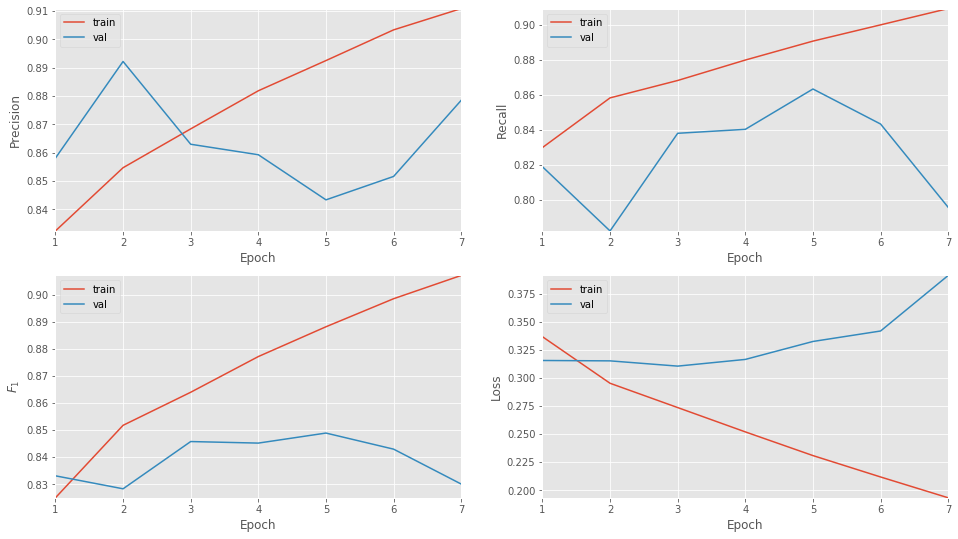

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [20]:
model.load_weights('LSTM-frozen-embeddings-05-0.85.hdf5')

In [21]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.85812   0.83974   0.84883     22457
           1    0.84211   0.86026   0.85109     22313

    accuracy                        0.84997     44770
   macro avg    0.85011   0.85000   0.84996     44770
weighted avg    0.85014   0.84997   0.84995     44770



In [22]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с размороженными emdedding слоям

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 26, 200)           20000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                67840     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [23]:
checkpoint = ModelCheckpoint("LSTM-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

C:\Users\Nikita Khoriakov\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 134307 samples, validate on 44769 samples
Epoch 1/5
134307/134307 [==============================] - 933s 7ms/step - loss: 0.1799 - accuracy: 0.9183 - precision: 0.9179 - recall: 0.9187 - f1: 0.9158 - val_loss: 0.3778 - val_accuracy: 0.8504 - val_precision: 0.8602 - val_recall: 0.8403 - val_f1: 0.8456
Epoch 2/5
134307/134307 [==============================] - 930s 7ms/step - loss: 0.1504 - accuracy: 0.9329 - precision: 0.9335 - recall: 0.9321 - f1: 0.9307 - val_loss: 0.4160 - val_accuracy: 0.8496 - val_precision: 0.8542 - val_recall: 0.8466 - val_f1: 0.8459
Epoch 3/5
134307/134307 [==============================] - 920s 7ms/step - loss: 0.1276 - accuracy: 0.9442 - precision: 0.9443 - recall: 0.9442 - f1: 0.9425 - val_loss: 0.4567 - val_accuracy: 0.8488 - val_precision: 0.8553 - val_recall: 0.8433 - val_f1: 0.8448
Epoch 4/5
134307/134307 [==============================] - 913s 7ms/step - loss: 0.1072 - accuracy: 0.9539 - precision: 0.9543 - recall: 0.9534 - f1: 0.9524 - val_los

In [24]:
model.load_weights('LSTM-trainable-02-0.85.hdf5')

In [25]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.84956   0.85323   0.85139     22457
           1    0.85164   0.84794   0.84978     22313

    accuracy                        0.85059     44770
   macro avg    0.85060   0.85058   0.85059     44770
weighted avg    0.85060   0.85059   0.85059     44770

